In [ ]:
!pip install deepface

In [1]:
import redis
import os
from deepface import DeepFace 
import numpy as np
from tqdm import tqdm
from deepface.commons import functions
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [2]:
r = redis.StrictRedis(host="localhost", port='6379', db=0)

In [3]:
rep = []
for dirpath, dirnames, filenames in os.walk('E:\\tf_openpose\\5celeb\\data\\train\\'):
    for filename in filenames:
       img_path = f"{dirpath}\\{filename}"
       if  ".jpg" or ".png" in img_path:
           embedding_obj = DeepFace.represent(
               img_path=img_path,
               model_name="ArcFace",
               enforce_detection=False
           )
           embedding = embedding_obj[0]["embedding"]
           rep.append((img_path, embedding))


In [114]:
for img_path, embedding in rep:
    r.rpush(f"embedding: {img_path}", *embedding)
    # -> prefix key in redis ~ "embedding: "
    
r.keys()

23-12-28 17:23:08 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.
Top 1: Image Path: embedding: E:\tf_openpose\5celeb\data\train\ben_afflek\httpwwwallposterscomimagesPostersPFjpg.jpg 
 Similarity Score: 0.618150643437651
23-12-28 17:23:09 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


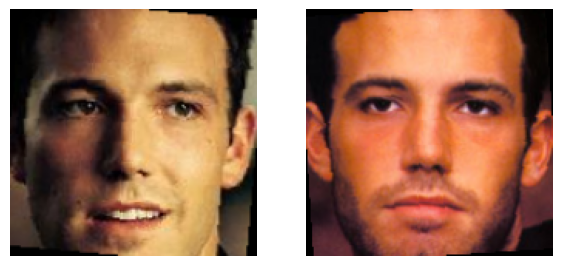

Top 2: Image Path: embedding: E:\tf_openpose\5celeb\data\train\ben_afflek\httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg 
 Similarity Score: 0.5675693202450681
23-12-28 17:23:09 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


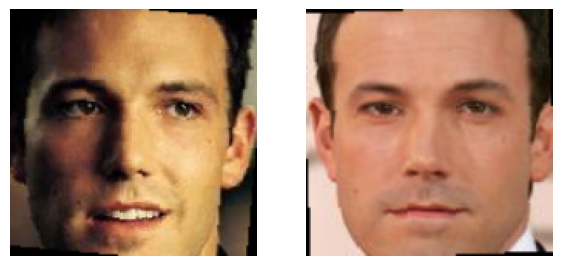

Top 3: Image Path: embedding: E:\tf_openpose\5celeb\data\train\ben_afflek\httpwwwaceshowbizcomimagesphotobenaffleckjpg.jpg 
 Similarity Score: 0.501460251630759
23-12-28 17:23:09 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


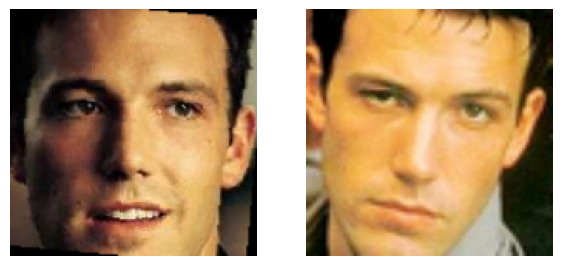

Top 4: Image Path: embedding: E:\tf_openpose\5celeb\data\train\ben_afflek\httpwwwfilmscoopitcgibinattoriBENAFFLECKBENAFFLECKjpg.jpg 
 Similarity Score: 0.4598826584294281
23-12-28 17:23:09 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


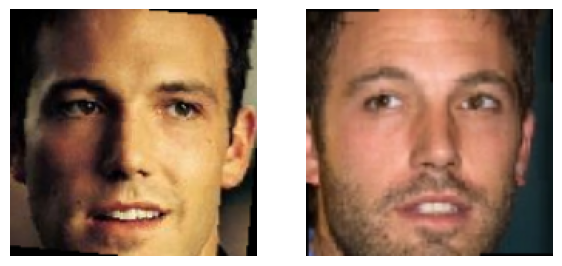

Top 5: Image Path: embedding: E:\tf_openpose\5celeb\data\train\ben_afflek\httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg 
 Similarity Score: 0.4515246367278345
23-12-28 17:23:09 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


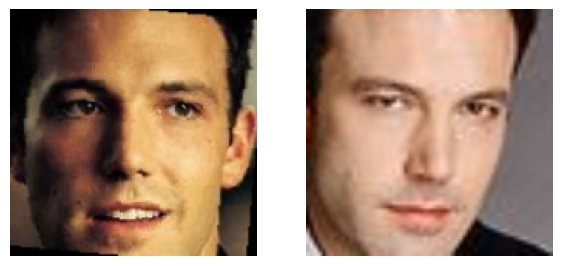

In [24]:
def get_embedding(image_path):
    embedding_obj = DeepFace.represent(
        img_path=image_path,
        model_name="ArcFace",
        enforce_detection=False
    )
    return embedding_obj[0]["embedding"]

def find_similar_images(query_embedding, redis_keys, redis_conn):
    similarities = []
    
    for key in redis_keys:
        stored_embedding = np.array(redis_conn.lrange(key, 0, -1), dtype=np.float32)
        sim_score = 1 - cosine(query_embedding, stored_embedding)
        similarities.append((key, sim_score))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities

query_image_path = "E:\\tf_openpose\\5celeb\\data\\val\\ben_afflek\\httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg"
target_img = functions.preprocess_face(query_image_path, target_size = (160, 160))

query_embedding = get_embedding(query_image_path)

prefix = "embedding: "
redis_keys = [key.decode("utf-8") for key in r.keys() if key.decode("utf-8").startswith(prefix)]

similar_images = find_similar_images(query_embedding, redis_keys, r)

top_n = 5
for i, (img_path, sim_score) in enumerate(similar_images[:top_n], 1):
    print(f"Top {i}: Image Path: {img_path} \n Similarity Score: {sim_score}")
    fig = plt.figure(figsize = (7, 7))
    
    ax1 = fig.add_subplot(1,2,1)
    plt.imshow(target_img[:, :, ::-1])
    plt.axis('off')
    
    ax2 = fig.add_subplot(1,2,2)
    _, ipath = img_path.split("embedding: ")

    source_img = functions.preprocess_face(ipath, target_size = (160, 160))
    plt.imshow(source_img[:, :, ::-1])
    plt.axis('off')
    
    plt.show()